In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import seaborn as sns

# Import datasets

In [2]:
csv_path = os.path.join("..", "..", "data","LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3_MICE5.csv")
tsr_all3_df = pd.read_csv(csv_path)
tsr_all3_df.shape

(39881, 234)

# Convert the multiple feature and outcome into binary ones

In [3]:
mRS3 = tsr_all3_df.mrs_tx_3
mRS3[(mRS3 == 0) | (mRS3 == 1) | (mRS3 == 2)] = 1 #GOOD
mRS3[(mRS3 == 3) | (mRS3 == 4) | (mRS3 == 5) | (mRS3 == 6) | (mRS3 == 9)] = 0 #BAD

<ipython-input-3-e1b78c8ad582>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mRS3[(mRS3 == 0) | (mRS3 == 1) | (mRS3 == 2)] = 1 #GOOD
<ipython-input-3-e1b78c8ad582>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mRS3[(mRS3 == 3) | (mRS3 == 4) | (mRS3 == 5) | (mRS3 == 6) | (mRS3 == 9)] = 0 #BAD


# Group all features and the outcome

In [4]:
nominal_features = ["edu_id", "pro_id", "opc_id", "toast_id", "offdt_id", "gender_tx", "hd_id", "pcva_id",
                    "pcvaci_id", "pcvach_id", "po_id", "ur_id", "sm_id", "ptia_id", "hc_id", "hcht_id",
                    "hchc_id", "ht_id", "dm_id", "pad_id", "al_id", "ca_id", "fahiid_parents_1",
                    "fahiid_parents_2", "fahiid_parents_3", "fahiid_parents_4", "fahiid_brsi_1",
                    "fahiid_brsi_2", "fahiid_brsi_3", "fahiid_brsi_4"]
ordinal_features = ["gcse_nm", "gcsv_nm", "gcsm_nm", "discharged_mrs", "feeding", "transfers",
                    "bathing", "toilet_use", "grooming", "mobility", "stairs", "dressing", "bowel_control",
                    "bladder_control", "nihs_1a_in", "nihs_1b_in", "nihs_1c_in", "nihs_2_in", "nihs_3_in", "nihs_4_in",
                    "nihs_5al_in", "nihs_5br_in", "nihs_6al_in", "nihs_6br_in", "nihs_7_in", "nihs_8_in", "nihs_9_in",
                    "nihs_10_in", "nihs_11_in", "nihs_1a_out", "nihs_1b_out", "nihs_1c_out", "nihs_2_out", "nihs_3_out",
                    "nihs_4_out", "nihs_5al_out", "nihs_5br_out", "nihs_6al_out", "nihs_6br_out", "nihs_7_out",
                    "nihs_8_out", "nihs_9_out", "nihs_10_out", "nihs_11_out"]
boolean = ["toastle_fl", "toastli_fl", "toastsce_fl", "toastsmo_fl", "toastsra_fl", "toastsdi_fl",
           "toastsmi_fl", "toastsantip_fl", "toastsau_fl", "toastshy_fl", "toastspr_fl", "toastsantit_fl",
           "toastsho_fl", "toastshys_fl", "toastsca_fl", "thda_fl", "thdh_fl", "thdi_fl", "thdam_fl", "thdv_fl",
           "thde_fl", "thdm_fl", "thdr_fl", "thdp_fl", "trman_fl", "trmas_fl", "trmti_fl", "trmhe_fl",
           "trmwa_fl", "trmia_fl", "trmfo_fl", "trmta_fl", "trmsd_fl", "trmre_fl", "trmen_fl", "trmag_fl",
           "trmcl_fl", "trmpl_fl", "trmlm_fl", "trmiv_fl", "trmve_fl", "trmng_fl", "trmdy_fl", "trmicu_fl",
           "trmsm_fl", "trmed_fl", "trmop_fl", "om_fl", "omas_fl", "omag_fl", "omti_fl", "omcl_fl", "omwa_fl",
           "ompl_fl", "omanh_fl", "omand_fl", "omli_fl", "am_fl", "amas_fl", "amag_fl", "amti_fl", "amcl_fl",
           "amwa_fl", "ampl_fl", "amanh_fl", "amand_fl", "amli_fl", "compn_fl", "comut_fl", "comug_fl",
           "compr_fl", "compu_fl", "comac_fl", "comse_fl", "comde_fl", "detst_fl", "dethe_fl", "detho_fl",
           "detha_fl", "detva_fl", "detre_fl", "detme_fl", "ct_fl", "mri_fl", "ecgl_fl", "ecga_fl", "ecgq_fl",
           "cortical_aca_ctr", "cortical_mca_ctr", "subcortical_aca_ctr", "subcortical_mca_ctr", "pca_cortex_ctr",
           "thalamus_ctr", "brainstem_ctr", "cerebellum_ctr", "watershed_ctr", "hemorrhagic_infarct_ctr",
           "old_stroke_ctci", "cortical_aca_ctl", "cortical_mca_ctl", "subcortical_aca_ctl", "subcortical_mca_ctl",
           "pca_cortex_ctl", "thalamus_ctl", "brainstem_ctl", "cerebellum_ctl", "watershed_ctl",
           "hemorrhagic_infarct_ctl", "old_stroke_ctch", "cortical_aca_mrir", "cortical_mca_mrir",
           "subcortical_aca_mrir", "subcortical_mca_mrir", "pca_cortex_mrir", "thalamus_mrir", "brainstem_mrir",
           "cerebellum_mrir", "watershed_mrir", "hemorrhagic_infarct_mrir", "old_stroke_mrici", "cortical_aca_mril",
           "cortical_mca_mril", "subcortical_aca_mril", "subcortical_mca_mril", "pca_cortex_mril",
           "thalamus_mril", "brainstem_mril", "cerebellum_mril", "watershed_mril", "hemorrhagic_infarct_mril",
           "old_stroke_mrich"]
continuous = ["height_nm", "weight_nm", "sbp_nm", "dbp_nm", "bt_nm", "hr_nm", "rr_nm", "hb_nm",
              "hct_nm", "platelet_nm", "wbc_nm", "ptt1_nm", "ptt2_nm", "ptinr_nm", "er_nm", "bun_nm",
              "cre_nm", "ua_nm", "tcho_nm", "tg_nm", "hdl_nm",
              "ldl_nm", "gpt_nm", "age", "hospitalised_time"]
labels = ["mrs_tx_3", "mrs_tx_1"]

# Machine Learning

## Preprocess input data (GOOD when Discharge)

In [5]:
## discharged mRS = GOOD (tsr_all3_df.discharged_mrs == 1)
mrs_dis1 = tsr_all3_df[(tsr_all3_df.discharged_mrs == 1) | (tsr_all3_df.discharged_mrs == 0) | (tsr_all3_df.discharged_mrs == 2)]

In [6]:
## input dataset
tsr_3G_input = mrs_dis1.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1)
print(tsr_3G_input.shape)
tsr_3G_input = tsr_3G_input.astype("float64")
tsr_3G_input = np.array(tsr_3G_input.values)

(18940, 230)


In [7]:
## output dataset
tsr_3G_output = mrs_dis1.mrs_tx_3
print(tsr_3G_output.shape)
tsr_3G_output = tsr_3G_output.astype("float64")
tsr_3G_output = np.array(tsr_3G_output.values)

(18940,)


In [8]:
## train_test_split
G_X_train, G_X_test, G_y_train, G_y_test = train_test_split(tsr_3G_input, tsr_3G_output, test_size=0.3, random_state=19)
print("The shape of GOOD's X_train:", G_X_train.shape)
print("The shape of GOOD's y_train:", G_y_train.shape)
print("The shape of GOOD's X_test:", G_X_test.shape)
print("The shape of GOOD's y_test:", G_y_test.shape)

The shape of GOOD's X_train: (13258, 230)
The shape of GOOD's y_train: (13258,)
The shape of GOOD's X_test: (5682, 230)
The shape of GOOD's y_test: (5682,)


In [9]:
## scale G_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
G_X_train = pd.DataFrame(G_X_train)
G_X_train.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1).columns

scaler = MinMaxScaler()
G_X_train[continuous] = scaler.fit_transform(G_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=6)
G_X_train[ordinal_features] = encoder.fit_transform(G_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")
nominal_train = ohe.fit_transform(G_X_train[nominal_features])
G_X_train = pd.concat([G_X_train, pd.DataFrame(nominal_train)], axis=1)
G_X_train = G_X_train.drop(nominal_features, axis=1)

G_x_train_columns = list(G_X_train.columns)
G_x_train_columns = G_x_train_columns[0:200]
get_feature_name = list(ohe.get_feature_names(nominal_features))
G_x_train_columns = G_x_train_columns+get_feature_name

G_X_train = np.array(G_X_train.values)

In [10]:
## scale G_X_test
G_X_test = pd.DataFrame(G_X_test)
G_X_test.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1).columns

G_X_test[continuous] = scaler.transform(G_X_test[continuous])

G_X_test[ordinal_features] = encoder.transform(G_X_test[ordinal_features])

nominal_test = ohe.transform(G_X_test[nominal_features])
G_X_test = pd.concat([G_X_test, pd.DataFrame(nominal_test)], axis=1)
G_X_test = G_X_test.drop(nominal_features, axis=1)

G_X_test = np.array(G_X_test.values)

## Algorithms

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable

In [140]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net,self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x    

In [141]:
model = Net(n_feature = G_X_train.shape[1], n_hidden = 10, n_output = 1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4)

In [142]:
G_X_train_tensor = Variable(torch.from_numpy(G_X_train)).float()
G_y_train_tensor = Variable(torch.from_numpy(G_y_train)).float()
G_X_test_tensor = Variable(torch.from_numpy(G_X_test)).float()
G_y_test_tensor = Variable(torch.from_numpy(G_y_test)).float()

In [143]:
import tqdm

In [144]:
num_epochs = 100
for epoch in  range(num_epochs):
    inputs = G_X_train_tensor
    target = G_y_train_tensor
    out = model(inputs)
    loss = criterion(out[:,0],target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 ==0:
        print("Epoch[{}/{}], loss: {:.6f}".format(epoch+1,num_epochs, loss.item()))

Epoch[5/100], loss: 0.976756
Epoch[10/100], loss: 0.948537
Epoch[15/100], loss: 0.921823
Epoch[20/100], loss: 0.896485
Epoch[25/100], loss: 0.872482
Epoch[30/100], loss: 0.849720
Epoch[35/100], loss: 0.828125
Epoch[40/100], loss: 0.807638
Epoch[45/100], loss: 0.788167
Epoch[50/100], loss: 0.769671
Epoch[55/100], loss: 0.752075
Epoch[60/100], loss: 0.735348
Epoch[65/100], loss: 0.719473
Epoch[70/100], loss: 0.704430
Epoch[75/100], loss: 0.690199
Epoch[80/100], loss: 0.676748
Epoch[85/100], loss: 0.664082
Epoch[90/100], loss: 0.652159
Epoch[95/100], loss: 0.640959
Epoch[100/100], loss: 0.630478


In [145]:
model.eval()
predict = model(G_X_train_tensor)
predict = predict.data.numpy()
print(predict)

[[0.15884767]
 [0.28524306]
 [0.20067349]
 ...
 [0.2606528 ]
 [0.2333013 ]
 [0.22585903]]


In [133]:
from sklearn.metrics import auc, roc_curve
predict = model(G_X_train_tensor)
predict = predict.data.numpy()
#print(predict)
fpr, tpr, thresholds = roc_curve(G_y_train_tensor, predict)
G_train_auroc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc)

ValueError: y should be a 1d array, got an array of shape (13258, 2) instead.

In [89]:
predict = model(G_X_test_tensor)
predict = predict.data.numpy()
#print(predict)
fpr, tpr, thresholds = roc_curve(G_y_test_tensor, predict)
G_train_auroc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc)

AUC of training set: 0.4604028147279925


In [498]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self, input_dataset):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dataset, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim = 1) # dim = 1 -> compute by rows
        return x

In [499]:
model = Model(G_X_train_tl.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)
model

Model(
  (layer1): Linear(in_features=310, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=2, bias=True)
)

In [500]:
import tqdm
EPOCHS = 100
G_X_train_tl = Variable(torch.from_numpy(G_X_train_tl)).float()
G_y_train_tl = Variable(torch.from_numpy(G_y_train_tl)).long()
G_X_test = Variable(torch.from_numpy(G_X_test)).float()
G_y_test = Variable(torch.from_numpy(G_y_test)).long()

In [486]:
G_X_train_tl = G_X_train_tl.to(device)
G_y_train_tl = G_y_train_tl.to(device)
G_X_test = G_X_test.to(device)
G_y_test = G_y_test.to(device)

In [501]:
loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(G_X_train_tl)
    loss = loss_fn(y_pred, G_y_train_tl)
    loss_list[epoch] = loss.item()

    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(G_X_test)
        correct = (torch.argmax(y_pred, dim=1) == G_y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:01<00:00, 61.07it/s]


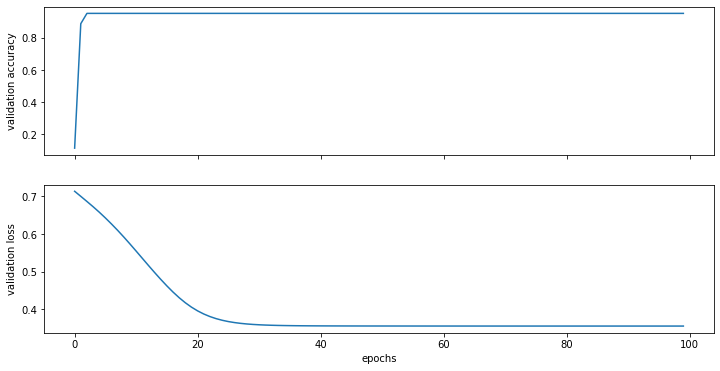

In [502]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
plt.show()

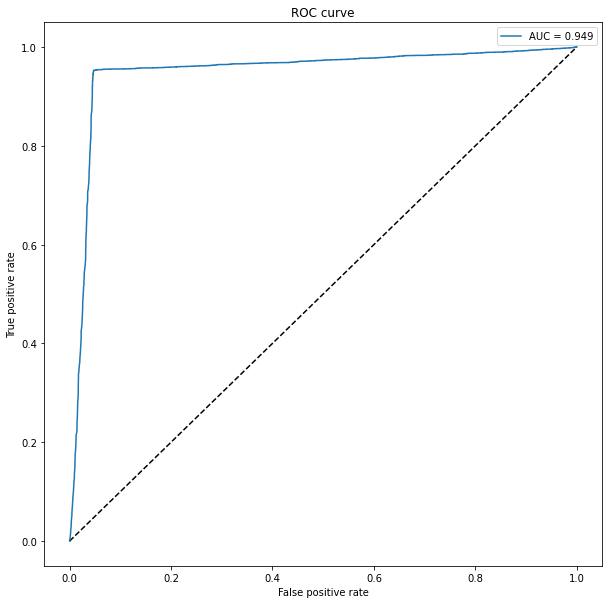

In [503]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(G_y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(G_X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()